# Develops the Calculation Model for the Online Calculator

In [64]:
import sys
from math import nan, isnan, inf
import numbers
from importlib import reload
import inspect
import pandas as pd
import numpy as np
# import matplotlib pyplot commands
from matplotlib.pyplot import *
from IPython.display import Image, Markdown
 
# Show Plots in the Notebook
%matplotlib inline
 
# 'style' the plot like fivethirtyeight.com website
style.use('bmh')

In [2]:
rcParams['figure.figsize']= (10, 6)   # set Chart Size
rcParams['font.size'] = 14            # set Font size in Chart

In [3]:
# Access the directory where some utility modules are located in the
# actual heat pump calculator.
sys.path.insert(0, '../../heat-pump-calc/heatpump/')

In [4]:
import library as lib
reload(lib)

<module 'library' from '../../heat-pump-calc/heatpump/library.py'>

In [65]:
def chg_nonnum(val, sub_val):
    """Changes a nan or anything that is not a number to 'sub_val'.  
    Otherwise returns val.
    """
    if isinstance(val, numbers.Number):
        if isnan(val):
            return sub_val
        else:
            return val
    else:
        return sub_val


class ElecCostCalc:
    """Class to calculate monthly electric cost given a block rate structure possibly including
    PCE.
    """

    def __init__(
        self,
        util_id, 
        sales_tax=0.0,      
        pce_limit=500.0,
        blocks=nan,  
        pce=nan,            
        demand_charge=nan,  
        customer_charge=nan,
        ):
        """Constructor parameters:
        util_id:            ID of the electric utility rate structure to use.  If math.nan
                                is passed, then the rate element overrides below must be utilized.
        sales_tax:          sales tax to apply to total electric bill.
        pce_limit:          maximum number kWh that PCE can apply to. 
                                use math.nan or math.inf to indicate no limit.
        blocks:             if provided, this list of (block_kwh, block_rate) will override
                                the blocks provided by the utility rate structure.
                                block_kwh is max kWh for block, block_rate is $/kWh.
                                Rates must include all fuel, purchased power and other
                                surcharges, except sales tax.
        pce:                if provided this PCE rate in $/kWh overrides the PCE rate in the
                                utility rate structure.
        demand_charge:      if provided this demand charge in $/kW overrides the demand
                                charge in the utility rate structure.
        customer_charge:    if provided, this customer charge in $ overrides the customer
                                charge in the utility rate stucture.
        """
        # save some of the variables for use in other methods
        # add Sales Tax to any rate elements
        self.utility = lib.util_from_id(util_id) if not isnan(util_id) else nan
        self.demand_charge =  chg_nonnum(self.utility.DemandCharge if isnan(demand_charge) else demand_charge, 0.0)
        self.demand_charge *= (1. + sales_tax)
        self.customer_charge =  chg_nonnum(self.utility.CustomerChg if isnan(customer_charge) else customer_charge, 0.0)
        self.customer_charge *= (1. + sales_tax)

        # Make a set of blocks that:
        #   * have the quantity of kWh in the block instead of the block upper limit kWh
        #   * include a block to accomodate a PCE limit
        #   * account for the effects of PCE

        # Convert PCE limit to infinite if no limit
        pce_limit = chg_nonnum(pce_limit, inf)

        if pce_limit > 0:
            # get the correct PCE rate and convert anyting not a number to 0.
            pce_adj = chg_nonnum(self.utility.PCE if isnan(pce) else pce, 0.0)
        else:
            pce_adj = 0.0

        # Flag to indicate whether a PCE block has been added.  If PCE is zero
        # no need to add a block.        
        pce_block_added = (pce_adj==0.0)  

        # Make a new set of blocks that includes the PCE limit as a new block
        # and the set is only as long as it needs to be.
        try:
            iter(blocks)    # will error if blocks is not iterable
            selected_blocks = blocks
        except TypeError:
            selected_blocks = self.utility.Blocks
        done = False
        temp_blocks = []
        for max_kwh, rate in selected_blocks:
            b_kwh = chg_nonnum(max_kwh, inf)
            done = (b_kwh == inf)

            # Determine whether it is time to insert the PCE block or not.
            # Test is whether block quantity exceeds the PCE limit.
            if not pce_block_added and (b_kwh > pce_limit):
                # Need to insert the PCE block now.
                temp_blocks.append( (pce_limit, rate) )
                pce_block_added = True          # PCE block has now been added.

            # address the case where the PCE limit matches the upper block
            if pce_limit == b_kwh:
                pce_block_added = True

            # add the block
            temp_blocks.append( (b_kwh, rate))

            if done:
                break

        # Include the PCE adjustment, and sales tax.
        # Also, convert the block quantities so that they are the quantity of 
        # kWh in the block instead of the upper limit of the block.
        prev_upper = 0.0
        self.__blocks = []    # final block list
        for max_kwh, rate in temp_blocks:
            if max_kwh <= pce_limit:
                rate -= pce_adj
            rate *= (1. + sales_tax)
            self.__blocks.append( (max_kwh - prev_upper, rate) )
            prev_upper = max_kwh

    def monthly_cost(self, kwh_energy, kw_demand=0.0):
        """Returns the total electric cost for a month, given energy usage of
        'kwh_energy' and peak demand of 'kw_demand'.
        """
        # customer charge
        cost = self.customer_charge

        # demand charge
        cost += kw_demand * self.demand_charge

        remaining_kwh = kwh_energy
        for b_kwh, b_rate in self.__blocks:
            kwh_in_block = min(remaining_kwh, b_kwh)
            cost += kwh_in_block * b_rate
            remaining_kwh -= kwh_in_block
            if remaining_kwh < 0.1:         # 0.1 kWh in case of rounding issues
                break
        
        return cost

    def final_blocks(self):
        """Debug method to return underlying rate blocks
        """
        return self.__blocks

In [32]:
class HomeEnergyModel(object):
    
    def __init__(self,
                 city_id,
                 hp_model_id,
                 exist_heat_fuel_id,
                 exist_heat_effic,
                 exist_kwh_per_mmbtu,     # Boiler: 5.5, Toyo: 3, Oil Furnace: 8.75 - 15
                 exist_is_point_source,
                 co2_lbs_per_kwh,
                 low_temp_cutoff,
                 garage_stall_count,
                 garage_heated_by_hp,
                 bldg_floor_area,
                 indoor_heat_setpoint,
                 insul_level,             # 1 - 2x4, 2 - 2x6, 3 - better than 2x6 Walls
                 pct_exposed_to_hp,
                 doors_open_to_adjacent,
                 low_temp_acceptance,     # 1 - no temp drop in back rooms, 2 - 4 deg F cooler, 10 deg F cooler

                 # The inputs below are not user inputs, they control the 
                 # calculation process. They are give default values.
                 hp_only=False,           # when using heat pump, it's the only heat source for home
                 no_heat_pump_use=False,  # If True, models existing heating system alone.
                 ua_true_up=1.0,          # used to true up calculaion to actual fuel use
                 **kwargs
                ):
        
        # Store all of these input parameters as object attributes
        args, _, _, values = inspect.getargvalues(inspect.currentframe())
        for arg in args[1:]:
            setattr(self, arg, values[arg])

    def __repr__(self):
        """Returns a string with all the object attributes shown.  Text is truncated
        at 1,000 characters for attributes with long representations.
        """
        s = ''
        for attr in self.__dict__:
            val = repr(self.__dict__[attr])[:1000]
            if len(val)>70:
                s+=f'\n{attr}:\n{val}\n\n'
            else:
                s += f'{attr}: {val}\n'
        return s
    
    # ------- Data needed for calculation of COP vs. Temperature
    
    # Piecewise linear COP vs. outdoor temperature.
    COP_vs_TEMP = (
        (-20.0, 1.1),
        (0.0, 2.0),
        (10.0, 2.2),
        (15.0, 2.3),
        (20.0, 2.5),
        (25.0, 2.7),
        (30.0, 2.8),
        (40.0, 3.0),
        (50.0, 3.2)
    )

    # convert to separate lists of temperatures and COPs
    TEMPS_FIT, COPS_FIT = tuple(zip(*COP_vs_TEMP))

    # The HSPF value that this curve is associated with
    BASE_HSPF = 13.3
    
    # ---------------- Main Calculation Method --------------------
    
    def calculate(self):
        """Main calculation routine that models the home and determines
        loads and fuel use by hour.  Also calculates summary results.
        """
        # Set up some shortcut variables to shorten calculation code
        s = self
        
        # ------ Create object variables from the input IDs
        s.city = lib.city_from_id(s.city_id)
        s.hp_model = lib.heat_pump_from_id(s.hp_model_id)
        s.exist_heat_fuel = lib.fuel_from_id(s.exist_heat_fuel_id)
        
        # ------ Make a DataFrame with hourly input information
        # Do as much processing at this level using array operations, as
        # opposed to processing within the hourly loop further below.
        
        df_tmy = lib.tmy_from_id(self.city.TMYid)
        s.df_hourly = df_tmy[['db_temp']].copy()
        # and now make a shorthand variable for this DataFrame
        dfh = s.df_hourly
        dfh['day_of_year'] = dfh.index.dayofyear
        dfh['month'] = dfh.index.month

        # Determine days that the heat pump is running.  Look at the minimum
        # temperature for the day, and ensure that it is above the low 
        # temperature cutoff.
        hp_is_running = lambda x: (x.min() > self.low_temp_cutoff)
        dfh['running'] = dfh.groupby('day_of_year')['db_temp'].transform(hp_is_running)

        # Determine a heat pump COP for each hour
        # ** NEED TO ADJUST FOR INDOOR SETPOINT and MOUNTING LOCATION OF INDOOR UNITS 
        cop_interp = np.interp(dfh.db_temp, 
                               HomeEnergyModel.TEMPS_FIT, 
                               HomeEnergyModel.COPS_FIT)
        dfh['cop'] = cop_interp * self.hp_model.hspf / HomeEnergyModel.BASE_HSPF

        # adjustment to UA for insulation level.  My estimate, accounting
        # for better insulation *and* air-tightness as you move up the 
        # insulation scale.
        ua_insul_adj_arr = np.array([1.25, 1.0, 0.75])   # the adjustment factors by insulation level
        ua_insul_adj = ua_insul_adj_arr[s.insul_level - 1]   # pick the appropriate one
        
        # The UA values below are Btu/hr/deg-F
        # This is the UA / ft2 of the Level 2 (ua_insul_adj = 1) home
        # for the main living space.  Assume garage UA is about 10% higher
        # due to higher air leakage.
        # Determined this UA/ft2 below by modeling a typical Enstar home
        # and having the model estimate space heating use of about 1250 CCF.
        # See 'accessible_UA.ipynb'.
        ua_per_ft2 = 0.189
        ua_home = ua_per_ft2 * ua_insul_adj * s.bldg_floor_area * s.ua_true_up
        garage_area = (0, 14*22, 22*22, 36*25, 48*28)[s.garage_stall_count]
        ua_garage = ua_per_ft2 * 1.1 * ua_insul_adj * garage_area * s.ua_true_up

        # Balance Points of main home and garage
        # Assume a 10 deg F internal/solar heating effect for Level 2 insulation
        # in the main home and a 5 deg F heating effect in the garage.
        # Adjust the heating effect accordingly for other levels of insulation.
        htg_effect = np.array([10., 10., 10.]) / ua_insul_adj_arr
        balance_point_home = s.indoor_heat_setpoint - htg_effect[s.insul_level - 1]
        htg_effect = np.array([5.0, 5.0, 5.0]) / ua_insul_adj_arr  # fewer internal/solar in garage
        balance_point_garage = 55.0 - htg_effect[s.insul_level - 1]

        # BTU loads in the hour for the heat pump and for the secondary system.
        hp_load = []
        secondary_load = []

        # More complicated calculations are done in this hourly loop.  If processing
        # time becomes a problem, try to convert the calculations below into array
        # operations that can be done outside the loop.
        for h in dfh.itertuples():
            # calculate total heat load for the hour.
            # Really need to recognize that delta-T to outdoors is lower in the adjacent and remote spaces
            # if there heat pump is the only source of heat.
            home_load = max(0.0, balance_point_home - h.db_temp) * ua_home 
            garage_load = max(0.0, balance_point_garage - h.db_temp) * ua_garage
            total_load = home_load + garage_load
            if not h.running or s.no_heat_pump_use:
                hp_load.append(0.0)
                secondary_load.append(total_load)
            else:
                max_hp_output = s.hp_model.in_pwr_5F_max * h.cop * 3412.
                if s.hp_only:
                    hp_ld = min(home_load + garage_load * s.garage_heated_by_hp, max_hp_output)
                    hp_load.append(hp_ld)
                    secondary_load.append(total_load - hp_load)
                else:
                    # Nowhere near correct yet.  Just get a calc framework working.
                    hp_ld = min(home_load * s.pct_exposed_to_hp + garage_load * s.garage_heated_by_hp, max_hp_output)
                    hp_load.append(hp_ld)
                    secondary_load.append(total_load - hp_ld)

        dfh['hp_load'] = hp_load
        dfh['secondary_load'] = secondary_load

        # using array operations, calculate kWh use by the heat pump and 
        # the Btu use of secondary system.
        dfh['hp_kwh'] = dfh.hp_load / dfh.cop / 3412.
        dfh['secondary_fuel'] = dfh.secondary_load / s.exist_heat_effic
        dfh['secondary_kwh'] = dfh.secondary_load / 1e6 * s.exist_kwh_per_mmbtu  # auxiliary electric use
        
        # Store annual and monthly totals.
        # Annual totals is a Pandas Series.
        total_cols = ['hp_load', 'secondary_load', 'hp_kwh', 'secondary_fuel', 'secondary_kwh']
        s.df_monthly = dfh.groupby('month')[total_cols].sum()
        dfm = s.df_monthly    # shortcut variable
        
        # physical units for secondary fuel
        fuel = self.exist_heat_fuel
        dfm['secondary_fuel_units'] = dfm['secondary_fuel'] / fuel.btus

        # COP by month
        dfm['cop'] = dfm.hp_load / (dfm.hp_kwh * 3412.)   

        # Total kWh, heat pump + auxiliary of secondary system
        dfm['total_kwh'] = dfm.hp_kwh + dfm.secondary_kwh
        
        # convert Btu columns into MMBtu
        for col in ['hp_load', 'secondary_load', 'secondary_fuel']:
            dfm[col] = dfm[col] / 1e6
            
        # Total lbs of CO2 per month, counting electricity and fuel
        dfm['co2_lbs'] = dfm.total_kwh * s.co2_lbs_per_kwh + dfm.secondary_fuel * fuel.co2
        
        s.ser_annual = s.df_monthly.sum().drop(['cop'])
        # Add the seasonal COP to the annual results
        tot = s.ser_annual
        if tot.hp_kwh:
            s.ser_annual['cop'] =  tot.hp_load * 1e6 / tot.hp_kwh / 3412.
        else:
            s.ser_annual['cop'] = np.nan
        
    def monthly_results(self):
        """Returns a DataFrame of monthly results.
        """
        return self.df_monthly
    
    def annual_results(self):
        return self.ser_annual
                
    def secondary_fuel_use(self):
        """Returns secondary fuel use in physical units, and also returns the
        units label.
        """
        fuel = self.exist_heat_fuel
        return self.ser_annual.secondary_fuel_units, fuel.unit
    
    def report(self):
        use, unit = self.secondary_fuel_use()
        s = f'Heat Pump: {self.ser_annual.hp_kwh:,.0f} kWh, Secondary Fuel Use: {use:,.2f} {unit}'
        s += f'\nSeasonal COP: {self.ser_annual.cop:.2f}'
        return s

In [59]:
"""Provides a class to model the impact of a heat pump on
energy use and cost.
"""
from os.path import join

this_dir = '/home/tabb99/heat-pump-study/general'
data_dir = join(this_dir, 'data')

def make_pattern(esc, life):
    """Makes a numpy array of length (life + 1) containing an escalation pattern
    that starts with a 1.0 in year 1 and escalates at the rate of 'esc' per year.
    """
    pat = np.ones(life - 1) * (1 + esc)
    return np.insert(pat.cumprod(), 0, [0.0, 1.0])

class HP_model:

    def __init__(self,
                 city_id,
                 utility_id,
                 co2_lbs_per_kwh,
                 exist_heat_fuel_id,
                 exist_unit_fuel_cost,
                 exist_fuel_use,
                 exist_heat_effic,
                 exist_kwh_per_mmbtu,
                 exist_is_point_source,
                 includes_dhw,
                 dhw_occupant_count,
                 includes_dryer,
                 elec_use_jan,
                 elec_use_may,
                 hp_model_id,
                 low_temp_cutoff,
                 garage_stall_count,
                 garage_heated_by_hp,
                 bldg_floor_area,
                 indoor_heat_setpoint,
                 insul_level,  
                 pct_exposed_to_hp,
                 doors_open_to_adjacent,
                 low_temp_acceptance,
                ):

        # Store all of these input parameters as object attributes.
        args, _, _, values = inspect.getargvalues(inspect.currentframe())
        for arg in args[1:]:
            setattr(self, arg, values[arg])
            
        # Look up the objects associated with the IDs
        self.city = lib.city_from_id(city_id)
        self.utility = lib.util_from_id(utility_id)
        self.exist_fuel = lib.fuel_from_id(exist_heat_fuel_id)
        self.hp_model = lib.heat_pump_from_id(hp_model_id)
                    
        # Dummy results brought in below
        self.__df_monthly = pd.read_excel(join(data_dir, 'sample_monthly.xlsx'), index_col='month', sheet_name='with_pce')
        self.__df_monthly_no_pce = pd.read_excel(join(data_dir, 'sample_monthly.xlsx'), index_col='month', sheet_name='without_pce')

    def __repr__(self):
        """Returns a string with all the object attributes shown.  Text is truncated
        at 1,000 characters for attributes with long representations.
        """
        s = ''
        for attr in self.__dict__:
            val = repr(self.__dict__[attr])[:1000]
            if len(val)>70:
                s+=f'\n{attr}:\n{val}\n\n'
            else:
                s += f'{attr}: {val}\n'
        return s
        
    def check_inputs(self):
        pass
        
    def run(self):
        
        # shortcut for self
        s = self
        
        # shortcut to existing heating fuel
        fuel = s.exist_fuel
        
        # Create the home energy simulation object
        sim = HomeEnergyModel(
            city_id=s.city_id,
            hp_model_id=s.hp_model_id,
            exist_heat_fuel_id=s.exist_heat_fuel_id,
            exist_heat_effic=s.exist_heat_effic,
            exist_kwh_per_mmbtu=s.exist_kwh_per_mmbtu,    
            exist_is_point_source=s.exist_is_point_source,
            co2_lbs_per_kwh=s.co2_lbs_per_kwh,
            low_temp_cutoff=s.low_temp_cutoff,
            garage_stall_count=s.garage_stall_count,
            garage_heated_by_hp=s.garage_heated_by_hp,
            bldg_floor_area=s.bldg_floor_area,
            indoor_heat_setpoint=s.indoor_heat_setpoint,
            insul_level=s.insul_level,            
            pct_exposed_to_hp=s.pct_exposed_to_hp,
            doors_open_to_adjacent=s.doors_open_to_adjacent,
            low_temp_acceptance=s.low_temp_acceptance,    
        )
        
        # Match the existing space heating use if it is provided.  Do so by using
        # the UA true up factor.
        # **** TO DO Deal with Electric Heat.  Calculate a space_fuel_use for electric
        # **** and then use the same calculation below.
        if s.exist_fuel_use is not None:
            
            # Remove DHW and Clothes dryer if they are present in the fuel use
            # number.
            space_fuel_use = s.exist_fuel_use
            if s.includes_dhw:
                dhw_use = s.dhw_occupant_count * 4.23e6 / fuel.dhw_effic / fuel.btus
                space_fuel_use -= dhw_use
                
            if s.includes_dryer:
                space_fuel_use -= 2.15e6 * s.dhw_occupant_count / fuel.btus
            
            sim.no_heat_pump_use = True
            sim.calculate()
            fuel_use1, _ = sim.secondary_fuel_use()
            
            # scale the UA linearly to attempt to match the target fuel use
            ua_true_up = space_fuel_use / fuel_use1
            sim.ua_true_up = ua_true_up
            sim.calculate()
            fuel_use2, _ = sim.secondary_fuel_use()
            
            # In case it wasn't linear, inter/extrapolate to the final ua_true_up
            slope = (fuel_use2 - fuel_use1)/(ua_true_up - 1.0)
            ua_true_up = 1.0 + (space_fuel_use - fuel_use1) / slope

        else:
            ua_true_up = 1.0
            
        print(f'UA True Up: {ua_true_up:.2f}')
        # Set the UA true up value into the model
        sim.ua_true_up = ua_true_up
        
        # Run the base case with no heat pump and record energy results
        sim.no_heat_pump_use = True
        sim.calculate()
        print(sim.secondary_fuel_use())
        s.df_mo_en_base = sim.monthly_results()
        
        # Run the model with the heat pump and record energy results
        sim.no_heat_pump_use = False
        sim.calculate()
        s.df_mo_en_hp = sim.monthly_results()
        
        # The User supplied a January and a May kWh usage value that should
        # be used for the base case (no heat pump) total electricity use.
        # But, need to come up with a kWh value for every month.  Do that by
        # adjusting the kWh pattern available for this city.
        #
        # Determine the multiplier to adjust to the pattern to the actual.
        pat_use = np.array(s.city.avg_elec_usage)
        mult = (s.elec_use_jan - s.elec_use_may) / (pat_use[0] - pat_use[4])
        pat_use = mult * pat_use
        pat_use += s.elec_use_jan - pat_use[0]
            
    def monthly_results(self, ignore_pce=False):
        """Returns a Pandas DataFrame of monthly results.
        If 'ignore_pce' is True, does not include PCE subsidy in analysis.
        """

        return self.__df_monthly_no_pce.copy() if ignore_pce else self.__df_monthly.copy()

    def annual_results(self, ignore_pce=False):
        """Returns a Pandas Series of annual results.
        If 'ignore_pce' is True, does not include PCE subsidy in analysis.
        """
        ann = self.monthly_results(ignore_pce=ignore_pce).sum()
        # need to fix the COP annual entry, which is not a simple sum
        # of the monthly values.
        hp_load = (self.__df_monthly.cop * self.__df_monthly.elec_chg_kwh).sum()
        ann_cop = hp_load / ann.elec_chg_kwh
        ann['cop'] = ann_cop
        return ann

    def cash_flow(self, ignore_pce=False):
        """Returns a Pandas DataFrame showing cash flow impacts over the
        life of the heat pump.
        If 'ignore_pce' is True, does not include PCE subsidy in analysis.
        """
        life = 14    # years of life
        ann = self.annual_results(ignore_pce=ignore_pce)
        capital = np.zeros(life+1)
        capital[0] = 4500.
        operating = 20. * make_pattern(.02, life)
        fuel_cost_savings = -ann.fuel_chg_dol * make_pattern(.04, life)
        elec_cost_increase = ann.elec_chg_dol * make_pattern(.03, life)
        cash_flow = -capital + -operating + fuel_cost_savings - elec_cost_increase
        df = pd.DataFrame(
            {'capital_cost': capital,
             'operating_cost': operating,
             'fuel_cost_savings': fuel_cost_savings,
             'elec_cost_increase': elec_cost_increase,
             'cash_flow': cash_flow
            }
        )
        df.index.name = 'year'

        return df

    def irr(self, ignore_pce=False):
        """Returns the internal rate of return of the heat pump investment.
        If 'ignore_pce' is True, does not include PCE subsidy in analysis.
        """
        df_cash = self.cash_flow(ignore_pce=ignore_pce)
        return np.irr(df_cash.cash_flow)

    def npv(self, ignore_pce=False):
        """Returns the net present value of the heat pump investment.
        If 'ignore_pce' is True, does not include PCE subsidy in analysis.
        """
        df_cash = self.cash_flow(ignore_pce=ignore_pce)
        return np.npv(0.05, df_cash.cash_flow)


In [61]:
inputs = dict(
    city_id=1,
    utility_id=1,
    co2_lbs_per_kwh=1.1,
    exist_heat_fuel_id=2,
    exist_unit_fuel_cost=0.9,
    exist_fuel_use=1600,
    exist_heat_effic=.8,
    exist_kwh_per_mmbtu=8,
    exist_is_point_source=False,
    includes_dhw=True,
    dhw_occupant_count=3,
    includes_dryer=True,
    elec_use_jan=550,
    elec_use_may=400,
    hp_model_id=575,
    low_temp_cutoff=5,
    garage_stall_count=2,
    garage_heated_by_hp=False,
    bldg_floor_area=3600,
    indoor_heat_setpoint=70,
    insul_level=3,  
    pct_exposed_to_hp=0.46,
    doors_open_to_adjacent=False,
    low_temp_acceptance=2,
)

In [62]:
mc = HP_model(**inputs)
mc.run()

UA True Up: 1.12
(1326.8147507731192, 'ccf')
[550.         499.5068459  457.78164971 449.67728422 400.
 375.67422144 369.63475289 383.30023961 396.5812103  426.3477229
 463.80765901 494.0274081 ]


In [53]:
mc.df_mo_en_hp

,hp_load,secondary_load,hp_kwh,secondary_fuel,secondary_kwh,secondary_fuel_units,cop,total_kwh,co2_lbs
month,,,,,,,,,
1,3.577076,14.884842,379.331599,18.606052,119.078734,179.421911,2.763758,498.410333,2725.159464
2,4.693177,11.860057,516.958934,14.825071,94.880454,142.961147,2.660737,611.839388,2407.556624
3,5.734345,8.740977,606.323036,10.926221,69.927813,105.363748,2.771856,676.250848,2022.243756
4,3.544868,4.799484,338.500900,5.999356,38.395876,57.852995,3.069242,376.896776,1116.511060
5,1.481855,1.837111,132.367577,2.296388,14.696884,22.144534,3.281067,147.064462,430.448327
6,0.430376,0.510929,37.689314,0.638661,4.087430,6.158736,3.346727,41.776744,120.677749
7,0.196321,0.230941,17.100687,0.288676,1.847525,2.783759,3.364679,18.948212,54.618102
8,0.397006,0.472841,34.789257,0.591051,3.782727,5.699625,3.344594,38.571984,111.582161
9,1.113018,1.398174,100.360208,1.747717,11.185388,16.853586,3.250361,111.545596,327.183034


In [55]:
lib.city_from_id(1).avg_elec_usage

[674.3176110825001,
 616.54369648225,
 568.8020181537499,
 559.5290597065,
 502.68865773625,
 474.855271649,
 467.94495386925,
 483.58090842574995,
 498.77690241749997,
 532.8355384270001,
 575.696935941,
 610.274161992]

In [90]:
# Model an average Enstar Home, probably somewhere between an
# insulation level 1 and 2.  Space Heating for Average Enstar
# House is about 1326 CCF, from "accessible_UA.ipynb"
m = HomeEnergyModel(**inputs)
m.insul_level = 2
m.exist_heat_effic = 0.76
m.bldg_floor_area = 2100
m.garage_stall_count = 1
m.no_heat_pump_use = True
m.calculate()
f_level2, _ = m.secondary_fuel_use()
print(m.report())

m.insul_level = 1
m.calculate()
f_level1, _ = m.secondary_fuel_use()
print(m.report())

# Assuming 2/3 Level 2 and 1/3 Level 1
print(0.67 * f_level2 + 0.33 * f_level1)

Heat Pump: 0 kWh, Secondary Fuel Use: 1,119.83 ccf
Seasonal COP: nan
Heat Pump: 0 kWh, Secondary Fuel Use: 1,508.89 ccf
Seasonal COP: nan
1248.221167662787


In [29]:
m.no_heat_pump_use = False
m.exist_heat_fuel_id = 2
m.calculate()
print(m.ser_annual)
m.df_monthly

hp_load                    37.595857
secondary_load             71.884685
hp_kwh                   3883.520537
secondary_fuel             94.585111
secondary_kwh             575.077478
secondary_fuel_units      912.103293
total_kwh                4458.598015
co2_lbs                 15970.915862
cop                         2.837301
dtype: float64


,hp_load,secondary_load,hp_kwh,secondary_fuel,secondary_kwh,secondary_fuel_units,cop,total_kwh,co2_lbs
month,,,,,,,,,
1,3.380669,13.529213,357.488089,17.801596,108.233702,171.664375,2.771610,465.721791,2595.080668
2,4.356737,10.817647,478.805033,14.233746,86.541173,137.258877,2.666820,565.346206,2287.229055
3,5.407157,8.267036,570.441629,10.877679,66.136290,104.895654,2.778106,636.577919,1972.924193
4,3.650658,4.982854,347.649958,6.556387,39.862831,63.224559,3.077655,387.512789,1193.361314
5,1.995716,2.507190,177.525159,3.298934,20.057518,31.812285,3.294806,197.582677,603.316215
6,0.920083,1.097730,80.340397,1.444382,8.781842,13.928465,3.356481,89.122239,267.027142
7,0.631399,0.743510,54.960350,0.978302,5.948078,9.433966,3.367018,60.908428,181.460637
8,0.897758,1.069472,78.400630,1.407200,8.555774,13.569909,3.356066,86.956403,260.294397
9,1.625519,2.036938,145.211678,2.680182,16.295507,25.845535,3.280814,161.507184,491.239196


In [10]:
%%timeit
m.no_heat_pump_use = False
m.calculate()

285 ms ± 6.16 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [133]:
m

city_id: 1
hp_model_id: 575
exist_heat_fuel_id: 2
exist_heat_effic: 0.76
heat_effic_true_up: 1.0
exist_kwh_per_mmbtu: 4.0
exist_is_point_source: False
exist_annual_fuel_use: None
includes_dhw: False
dhw_occupant_count: 3
co2_lbs_per_kwh: 1.7
low_temp_cutoff: 5.0
garage_stall_count: 1
garage_heated_by_hp: False
bldg_floor_area: 2100
indoor_heat_setpoint: 70.0
insul_level: 1
ua_true_up: 1.0
pct_exposed_to_hp: 0.46
doors_open_to_adjacent: False
low_temp_acceptance: 2
hp_only: False
no_heat_pump_use: True

city:
Name                                                         Anchorage
Latitude                                                        61.152
Longitude                                                     -149.864
ERHRegionID                                                          2
WAPRegionID                                                          2
FuelRefer                                                        False
FuelCityID                                                  

In [173]:
m.df_hourly.head()

,db_temp,day_of_year,month,running,cop,hp_load,secondary_load,hp_kwh,secondary_fuel
timestamp,,,,,,,,,
2018-01-01 00:30:00,21.02,1,1,True,2.674526,0.0,20926.81122,0.0,27535.277921
2018-01-01 01:30:00,19.94,1,1,True,2.629053,0.0,21499.68534,0.0,28289.059658
2018-01-01 02:30:00,21.02,1,1,True,2.674526,0.0,20926.81122,0.0,27535.277921
2018-01-01 03:30:00,19.04,1,1,True,2.591158,0.0,21977.08044,0.0,28917.211105
2018-01-01 04:30:00,19.04,1,1,True,2.591158,0.0,21977.08044,0.0,28917.211105


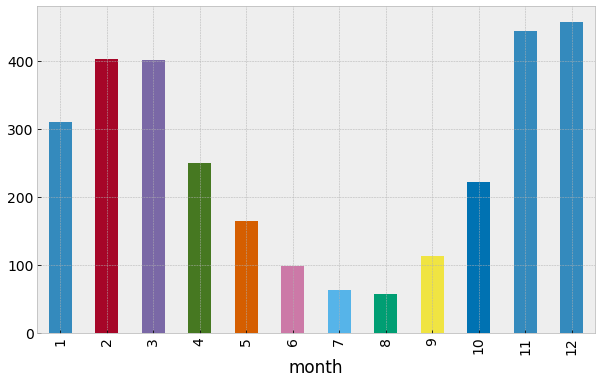

In [109]:
df_mo = m.df_hourly.groupby('month')[['hp_kwh', 'secondary_fuel']].sum()
df_mo.hp_kwh.plot(kind='bar')

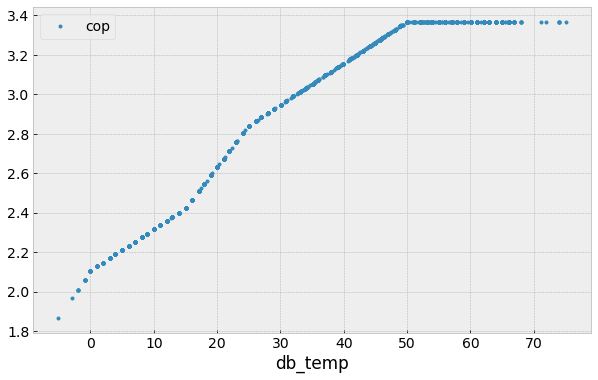

In [110]:
# Check whether COP is getting modeled correctly
m.df_hourly.plot(x='db_temp', y='cop', marker='.', linewidth=0)